# Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps

Paper: https://arxiv.org/abs/1312.6034

In [1]:
import json
from pathlib import Path
from tqdm.notebook import trange
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from itertools import product
from PIL import Image
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [2]:
def img_process(pil_img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[ 0.485, 0.456, 0.406 ],
                             std=[ 0.229, 0.224, 0.225 ]),
    ])
    return transform(pil_img).unsqueeze(0)

def mask_out(x):
    x[x < 0.0] = 0.0
    x[x > 1.0] = 1.0
    return x

def img_inv_process(tensor):
    if tensor.ndim == 4:
        tensor = tensor.squeeze(0)
    inv_transform = transforms.Compose([
        transforms.Normalize(
            mean=[ -0.485/0.229, -0.456/0.224, -0.406/0.225 ],
            std=[ 1/0.229, 1/0.224, 1/0.225 ]
        ), 
        transforms.Lambda(mask_out),
        transforms.ToPILImage()
    ])
    return inv_transform(tensor)


def save_image(img, path):
    img.save(path)

def open_img(img_path, resize=None, crop=None):
    img = Image.open(img_path)
    if resize is not None:
        assert isinstance(resize, int), "insert int number for resize"
        tf = [transforms.Resize(resize)] 
        if crop is not None:
            tf += [transforms.CenterCrop(crop)]
        transform_resize = transforms.Compose(tf)
        img = transform_resize(img)
    return img
    
def init_img(img_path, zero=False, resize=None, crop=False, device="cpu"):
    img = open_img(img_path, resize, crop)
    img_tensor = img_process(img).to(device)
    if zero:
        img_tensor = torch.zeros_like(img_tensor)
    return img_tensor

In [3]:
img_path = "./data/Image/flamingo.jpg"
img_tensor = init_img(img_path, resize=256, crop=224)
class_to_labels = json.load(open("./data/Image/imagenet1000_clsidx_to_labels.json", 
                                 "r", encoding="utf-8"))
inv_class_to_labels = {v: k for k, v in class_to_labels.items()}
model = models.resnet152(pretrained=True)

In [4]:
def predict(x, model):
    model.eval()
    o = model(x)
    clsidx = o.argmax().item()
    return clsidx

clsidx = predict(img_tensor, model)
print(f"predicted class: {class_to_labels[str(clsidx)]} ({clsidx})")

predicted class: flamingo (130)


In [5]:
class Visualization(nn.Module):
    def __init__(self, model, regularizer, sv_dir="./data/generated", resize=None, crop=None):
        super(Visualization, self).__init__()
        self.model = deepcopy(model)
        self.model.eval()
        self.model.cpu()
        
        self.sv_dir = Path(sv_dir)
        self.check_path(self.sv_dir)
        
        self.resize = resize
        self.crop = crop
        
        self.reg_dict = {"l1": 1, "l2": 2}
        self.regularizer = regularizer
    
    def check_path(self, p):
        if not isinstance(p, Path):
            p = Path(p)
        if not p.exists():
            p.mkdir(parents=True)
    
    def class_model_visualization(self, img_path, target, lr=6.0, weight_decay=0.0, device="cpu"):
        sv_path = self.sv_dir / f"{target}" / f"{weight_decay}"
        self.check_path(sv_path)
        
        self.model.to(device)
        zero_img = init_img(img_path, zero=True, resize=self.resize, crop=self.crop)
        img_tensor = zero_img.to(device).requires_grad_(True)
        optimizer = optim.SGD([img_tensor], lr=lr)
        losses = []
        for i in trange(151):
            optimizer.zero_grad()
            output = self.model(img_tensor)
            reg = torch.norm(img_tensor, p=self.reg_dict[self.regularizer])
            loss = -output[0, target] + weight_decay * reg
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                losses.append(loss.item())
                pil_img = img_inv_process(img_tensor.clone().detach().cpu())
                sv_prefix = f""
                if weight_decay != 0.0:
                    sv_prefix += f"{self.regularizer}-"
                if self.resize is not None:
                    sv_prefix += f"{self.resize}-"
                if self.crop is not None:
                    sv_prefix += f"{self.crop}-"
                
                save_image(pil_img, str(sv_path / (sv_prefix + f"iter-{i}.jpg")))
                
        self.model.cpu()
        return pil_img, losses
    
    def generate_saliency_maps(self, img_path, target):
        img_tensor = init_img(img_path, resize=self.resize, crop=self.crop).requires_grad_(True)
        output = self.model(img_tensor)
        one_hot = torch.zeros_like(output).scatter(1, torch.LongTensor([target]).unsqueeze(1), 1.0)
        output.backward(one_hot)
        grad = img_tensor.grad.detach().clone()
        grad = torch.abs(grad).max(1)[0].squeeze(0)
        return grad

In [12]:
def experiment(model, img_path, target, lr, weight_decay, 
               device="cpu", resize=None, crop=None, regularizer="l2"):
    vis_model = Visualization(model, regularizer, resize=resize, crop=crop)
    img = open_img(img_path, resize=resize, crop=crop)
    clsimg, losses = vis_model.class_model_visualization(img_path, target, lr, weight_decay, device)
    saliency = vis_model.generate_saliency_maps(img_path, target)
    
    plt.plot(torch.arange(16)*10 , losses)
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    return img, clsimg, saliency
    
def show(cls, img, clsimg, saliency):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    
    axes[0].imshow(img)
    axes[1].imshow(clsimg)
    axes[2].imshow(saliency)
    axes[0].set_title(f"Class: {cls}", fontsize=12)
    axes[1].set_title("Class model visualization", fontsize=12)
    axes[2].set_title("Saliency Map", fontsize=12)
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [13]:
classes = ["flamingo", "banana", "tabby-cat"]
targets = [130, 954, 281]
weight_decays = [0.001, 0.1, 1.0]
regularizers = ["l1", "l2"]
img_path = "./data/Image/{}.jpg"
lr = 6.0
resize = 256
crop = 224
device = "cuda"

0.001-l1
flamingo


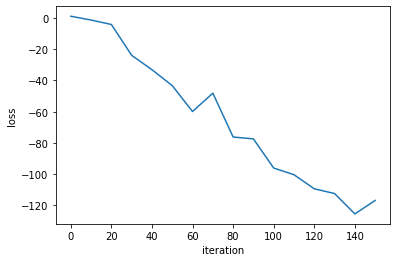

banana


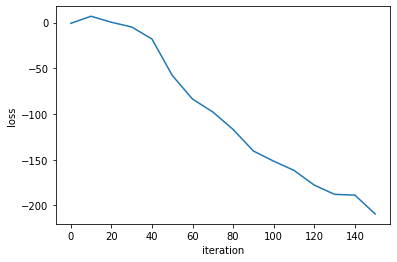

tabby-cat


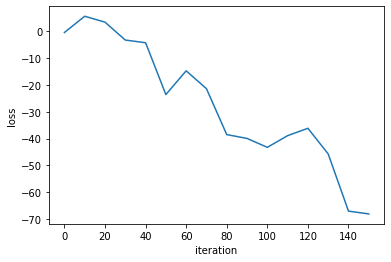

0.001-l2
flamingo


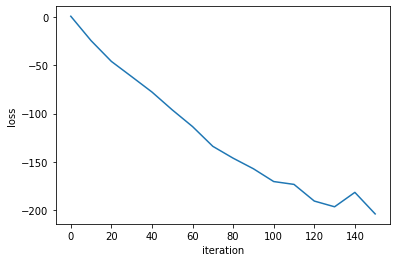

banana


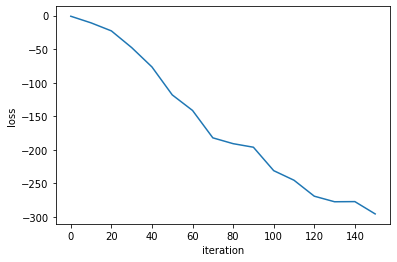

tabby-cat


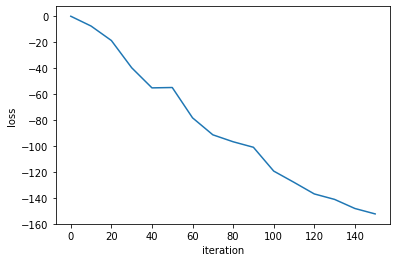

0.1-l1
flamingo


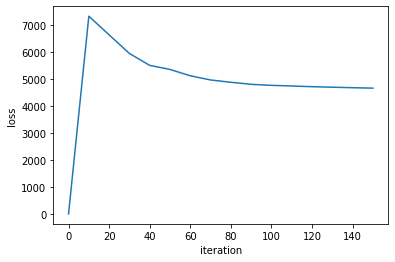

banana


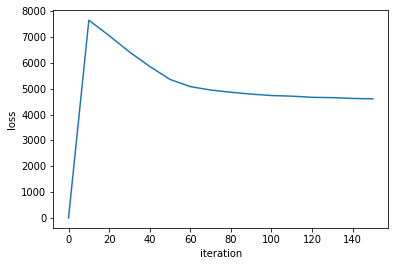

tabby-cat


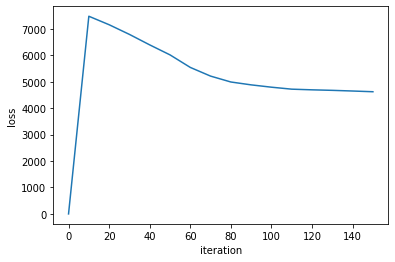

0.1-l2
flamingo


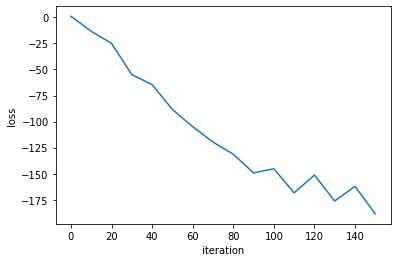

banana


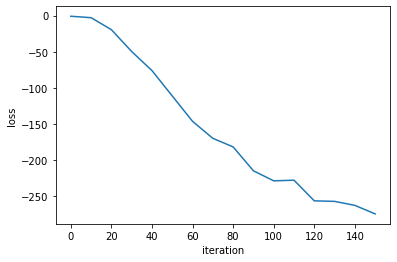

tabby-cat


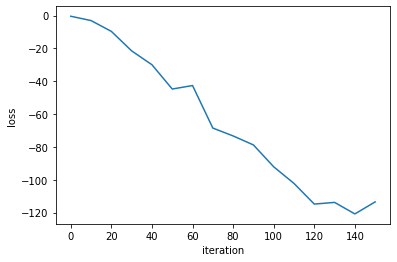

1.0-l1
flamingo


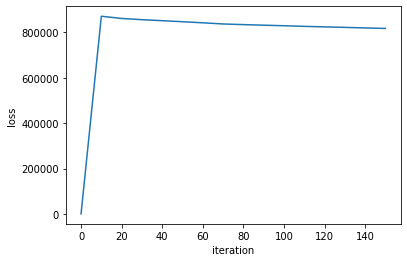

banana


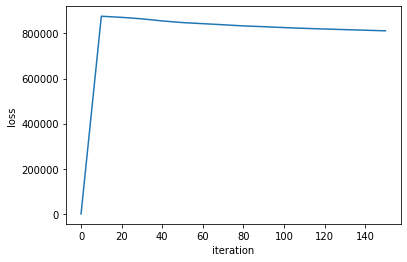

tabby-cat


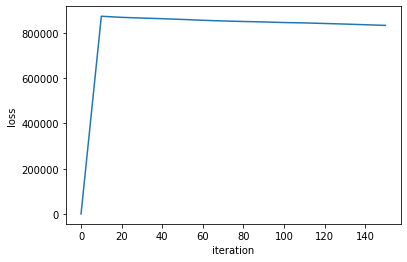

1.0-l2
flamingo


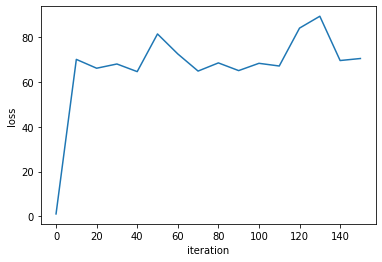

banana


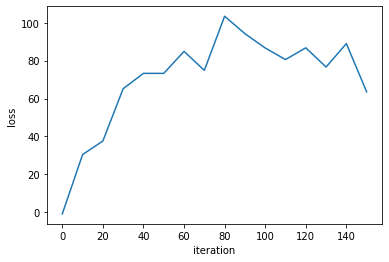

tabby-cat


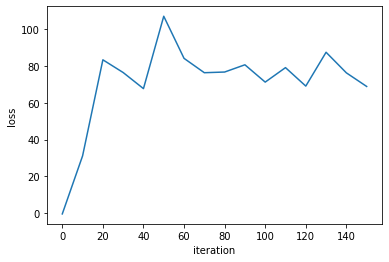

In [14]:
exp_dict = {}
for weight_decay, regularizer in product(*(weight_decays, regularizers)):
    exp_str = f"{weight_decay}-{regularizer}"
    print(exp_str)
    exp_dict[exp_str] = {}
    cls_dict = exp_dict[exp_str]
    for cls, target in zip(classes, targets):
        print(cls)
        img_p = img_path.format(cls)
        cls_dict[cls] = experiment(model, img_p, target, lr, weight_decay, 
                                   device, resize, crop, regularizer)

In [18]:
for weight_decay, regularizer in product(*(weight_decays, regularizers)):
    for cls, target in zip(classes, targets):
        p = Path(f"./data/generated/{target}/{weight_decay}/")
        find_name = f"{regularizer}-{resize}-{crop}-iter-*.jpg"
        imgs = sorted(list(p.glob(find_name)), 
                      key=lambda x: int(x.name.split("-")[-1].strip(".jpg")))

        frames = []
        for i in imgs:
            new_frame = Image.open(i)
            frames.append(new_frame)
        
        sv_name = find_name.strip('-iter-*.jpg')
        frames[0].save(str(p / f"{sv_name}.gif"), format='GIF',
                       append_images=frames[1:],
                       save_all=True,
                       duration=200, loop=0)

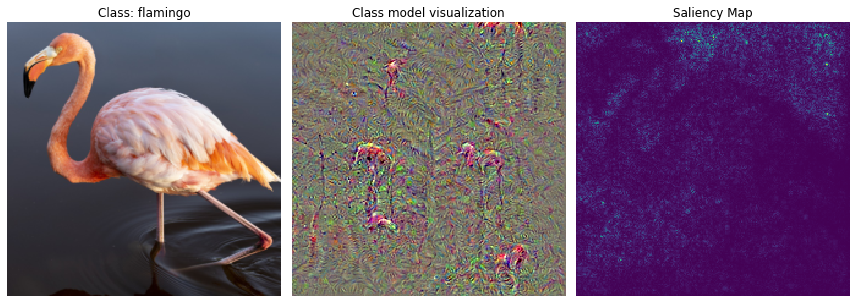

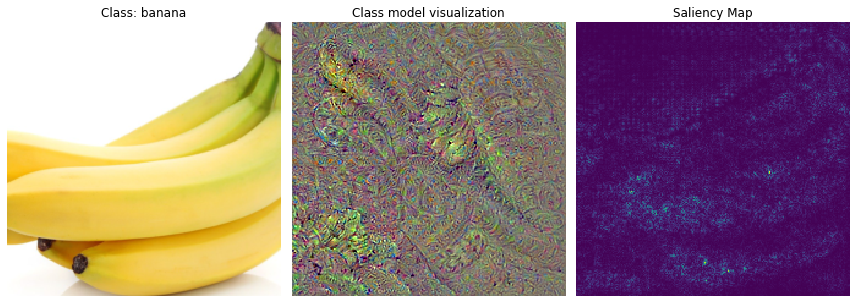

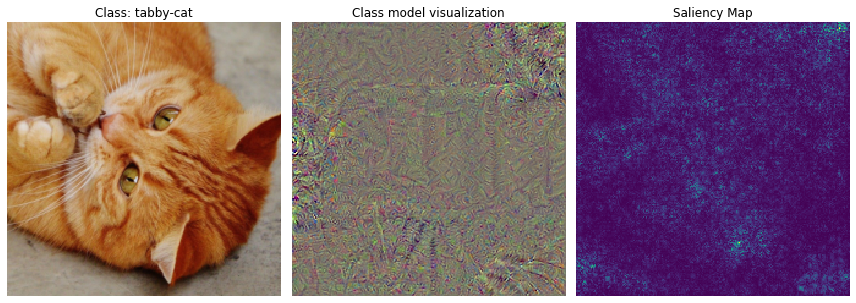

In [19]:
for cls, datas in cls_dict.items():
    show(cls, *datas)